# Naive bayesian decoder
This week's lecture will cover naive bayesian decoders. These rely on calculating the probability of some event occuring, $y$, as a function of spiking activity, $x$. Such decoders are easy to train and operate under a fundamentally different principle than the logistic classifiers we used in previous lectures. Moreover, they give us the opportunity to work with probability theory, which is something we only tangentially covered in previous lectures. 

In [1]:
import os
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import norm
from scipy.special import factorial
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from source.spikes import spikes_to_df, rf
from source.utils import poisson_pdf, zscore

/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Conditional probability

We already mentioned conditional probabilities when discussing how to interpret the logistic function. In that case, the logisitic function reflects the probability of a certain event occurring given the features in our data, $p(y|x)$, where $y$ is the event and $x$ are the features. Across all possible classes there will be a different $p(y_k|x)$, and the sum of those probabilities across all possible classes will be 1:

$$ \sum_{k=1}^{K}{p(y_k|x)} = 1 $$

When evaluating the probability across all classes, the $x$ is kept constant. 

The general way to express conditional probability is:

$$ p(y|x) = \frac{p(y,x)}{p(x)} \tag{eq. 1} $$

Here $p(y,x)$ is the probability that particular instances of $y$ and $x$ ever co-occur. If we divide that by the probability of $x$ occurring, $p(x)$, then we have the probability of $y$ *conditional* on $x$. That is, it is the probability of $y$ for all instances when $x$ is of a particular value.

When $y$ and $x$ are conditionally independent of one another then $p(y|x)=p(y)p(x)$. This just means that the chance of $y$ occurring with $x$ will equal to the probability that either of those happen in general (irrespective of each other). This is what is meant by conditional independence. 

## Bayes' theorem

Given equation 1 and a little algebra, we can establish a fundamental relationship between conditional probabilities known as Bayes' rule or theorem. Note that swapping $x$ and $y$, we get the equation $p(x|y)=\frac{p(x,y)}{p(y)}$, which can be rearranged to $p(x|y)p(y)=p(x,y)$. Also note that $p(y,x) = p(x,y)$. With these facts, we can write:

$$ \begin{align}
    p(y|x)p(x) &= p(y,x) = p(x,y) = p(x|y)p(y) \notag \\
    p(y|x)p(x) &= p(x|y)p(y) \notag \\
    p(y|x) &= \frac{p(x|y)p(y)}{p(x)} \tag{2} \\
    \end{align}
$$

This powerful relationship shows how to go from the conditional probability of $x$ given $y$, to that of $y$ given $x$. 

Why is this relaiontship important? Returning to decoders, their goal is to estimate the probability of behavioral or stimulus events, $y_k$, given patterns in brain activity, $x$. In the previous lectures we estimated this probability, $p(y_k|x)$ using logistic regression. The event $k$ with the largest probability was then chosen as the one most likely to have occured. However, Bayes' theorem offers an alternative approach. Instead we can derive that by measuring the probability of observing our brain data given that event $y_k$ occured and use that, along with our knowledge about how often $y_k$ occurs.

Bayes' theorem is so prominent that each term in it has a name:
1. $p(y|x)$ is the *posterior*. This is the probability of an event given the brain data.
2. $p(x|y)$ is the *likelihood*. This is the probability of the brain data given an event.
3. $p(y)$ is the *prior*. This is the probability of an event occuring.
4. $p(x)$ is the *evidence*. This is the probability of the observed brain data occuring.

Both the likelihood and prior can be determined from the data we have been working with so far. Less tractable is an estimate of the evidence, the probability of the brain data, because that would require us to observe all possible brain states. Fortunately, with classification we just want the event with the highest probability, and do not care about its *actual* probability. For a given decoding estimate, we want to estimate $p(y|x)$ for a certain brain state we observed, $x$. This means that the $p(x)$ in Bayes' rule will be held constant across all possible events, $y_k$. Thus, while we do not know the exact value of $p(x)$, it is just uniformly rescaling the values of $p(y|x)$ across all possible $y_k$. This will not change which $y_k$ is highest or lowest, so leaving it out has no impact on our ability to classify. As a result, our decoder can use the following rule:

$$ \text{selection} = \arg\max_{y_k}p(x|y)p(y) $$

Let's give this a try with a single neuron from the Allen Institute data set.

## Bayes' theorem and the single neuron

To start, we will load in the neurons from last week and select one with well defined tuning for orientation.

In [2]:
# initialize data cache
allen_dir = ['..','data','spike_allen']
manifest_path = os.path.join(*allen_dir,'manifest.json')
cache = EcephysProjectCache(manifest=manifest_path)

# get session
sess_id = 750332458
sess = cache.get_session_data(sess_id, filter_by_validity=False)
stims = sess.stimulus_presentations

# get the ids of the units that passed quality control last week
# save as an numpy file where the Allen cache is stored
ids_path = os.path.join(*allen_dir,'clean_unit_ids.npy')
unit_ids = np.load(ids_path)

# get stimulus presentations
dg_stims = stims[stims['stimulus_name'] == 'drifting_gratings']
dg_stims = dg_stims[(dg_stims['contrast']!='null') |
                    (dg_stims['spatial_frequency']!='null') |
                    (dg_stims['orientation']!='null') |
                    (dg_stims['temporal_frequency']!='null')]

# get the spike times as a dataframe
spikes = spikes_to_df(sess)

# keep only those rows whose index is in unit_ids
spikes = spikes[spikes.index.isin(unit_ids)]

# compute orientation RF for each unit
spikes['rf_ori'] = spikes['times'].apply(
    lambda x: rf(dg_stims, [0, 2]).compute(x, dims=['orientation']))

# get the empirical orientation tuning curve
spikes['rf_ori_emp'] = spikes['rf_ori'].apply(lambda x: x.rf())

/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Then we will load a selected neuron and extract its spike counts across trials.

In [3]:
sel_unit = 951815599
rf_ori_counts = spikes.loc[sel_unit,'rf_ori'].stim_counts
rf_ori_mean = spikes.loc[sel_unit,'rf_ori_emp']
ori_vals = rf_ori_mean[2][0]

We are interested in the distribution of those spike counts as a function of drifting grating orientation. We can use a violin plot to visualize that.

Text(0.5, 1.0, 'Orientation tuning curve for unit 951815599')

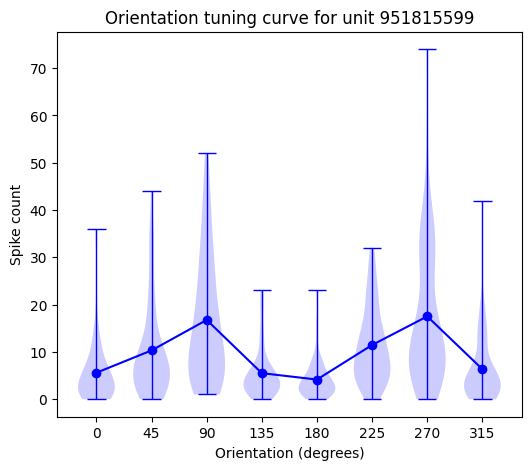

In [4]:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(ori_vals, rf_ori_mean[0].flatten(), 'o-', color='blue')


for ori, counts in rf_ori_counts.iterrows():
    vp = ax.violinplot(counts.values[0], positions=[ori], widths=30)
    vp['bodies'][0].set_facecolor('blue')
    vp['bodies'][0].set_alpha(0.2)
    for line in ['cmaxes', 'cmins', 'cbars']:
        vp[line].set_edgecolor('blue')
        vp[line].set_linewidth(1)
ax.set_xticks(ori_vals)
ax.set_xlabel('Orientation (degrees)')
ax.set_ylabel('Spike count')
ax.set_title('Orientation tuning curve for unit {}'.format(sel_unit))

An alternative way to visualize this is the probability of observing some spike count, $x$, and and orientation, $y$. This is expressed as $p(x,y)$.

We can do this by counting the number of times each number of spike counts occured for each orientation and placing that into an array. The rows will be the spike counts and the columns the orientations. This is just another example of binning. In previous lectures we binned spike times across time by counting the number of spikes in small intervals of time. That is, we grouped spikes together that fell in a time window and counted how many there were. Here, we are grouping trials based on the orientation presented and number of spikes that occured in response. 

To convert this to a probability, we divide the count in each bin by the total number of counts.

In [5]:
# range of values to bin over
num_stim = rf_ori_counts.shape[0] # number of stimuli
max_counts = int(rf_ori_counts['spike_counts'].apply(lambda x: x.max()).max()) # max spike count

# joint distribution of spike counts
joint_dist = np.zeros((max_counts+1, num_stim))
for i, (_, counts) in enumerate(rf_ori_counts.iterrows()):
    joint_dist[:,i] = np.histogram(counts.values[0], bins=np.arange(max_counts+2))[0]

# normalize by the total number of counts
joint_dist = joint_dist / joint_dist.sum()

Now that the probability has been calculated and stored in `joint_dist`, let's plot it.

Text(0.5, 1.0, 'Joint probability distribution of spike counts and orientation')

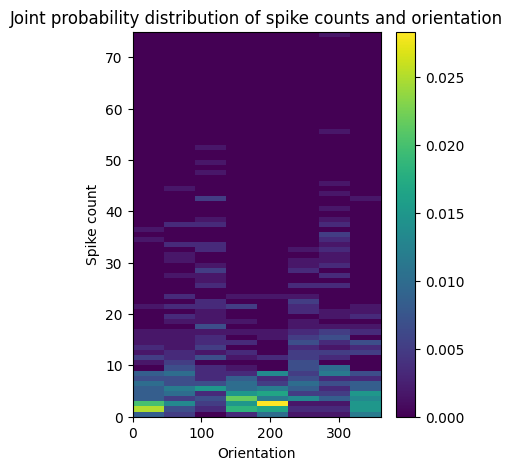

In [6]:
# grid of joint distribution points
x, y = np.meshgrid(np.append(ori_vals, 360), np.arange(max_counts+2))

fig, ax = plt.subplots(figsize=(4,5))
ax.pcolormesh(x, y, joint_dist)
fig.colorbar(ax=ax, mappable=ax.collections[0])
ax.set_xlabel('Orientation')
ax.set_ylabel('Spike count')
ax.set_title('Joint probability distribution of spike counts and orientation')

Notice that the probabitliies are not smooth but spotty and sometimes have gaps between them. This becomes easily seen if we color white those bins with 0 counts.

Text(0.5, 1.0, 'Joint probability distribution of spike counts and orientation')

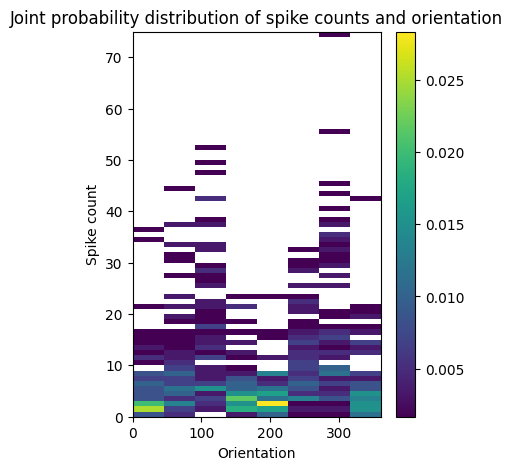

In [7]:
# remove zeros for better visualization
joint_dist_nan = joint_dist.copy()
joint_dist_nan[joint_dist_nan==0] = np.nan

fig, ax = plt.subplots(figsize=(4,5))
ax.pcolormesh(x,y,joint_dist_nan)
fig.colorbar(ax=ax, mappable=ax.collections[0])
ax.set_xlabel('Orientation')
ax.set_ylabel('Spike count')
ax.set_title('Joint probability distribution of spike counts and orientation')

Here we have some combinations of orientation and spike count that never occurred, and so they are given a probability of 0. For instance, there were no trials with an orientation of 45 degrees that had 17 spikes. But, there were trials when 45 degree oriented gratings were presented that had 16 or 18 spikes. 

In [8]:
print('Orientation of 45 degrees and spike count of 16: {:.3f} probability'.format(joint_dist[16,1]))
print('Orientation of 45 degrees and spike count of 17: {:.3f} probability'.format(joint_dist[17,1]))
print('Orientation of 45 degrees and spike count of 18: {:.3f} probability'.format(joint_dist[18,1]))

Orientation of 45 degrees and spike count of 16: 0.002 probability
Orientation of 45 degrees and spike count of 17: 0.000 probability
Orientation of 45 degrees and spike count of 18: 0.002 probability


This sparsity is, most likely, because we have only a finite number of trials to sample a neuron's response. This means our joint probability distribution will not be smooth. 

So now you might be wondering: Why is this a problem? If something never occurred, then shouldn't it have a probability of 0? Well, imagine we had only given a single presentation of each orientation, and constructed our joint probability distribution from that. In that case, we would only have one bin filled in for each orientation column, with the rest being 0. This extreme sparseness is because we did not sample the neuron's responses sufficiently. To overcome this, we would increase the number of trials. In theory, if we gave an infinite number of trials, we would expect a smooth joint probability distribution with no missing spots. 

Since it is impossible to give an infinite number of trials, we will instead fit a curve to the neuron's reponse to each stimulus. That curve will give an estimate of the neuron's response that is continuous. The challenge now is to choose the curve we want to use. In the last lecture we discussed how neuronal spike counts follow a poisson distribution, and fit a curve to those. We can do the same thing here, fitting the poisson response curve to each orientation.

To calculate the poisson probability distribution, $p(x) = \frac{\lambda^xe^{-x}}{x!}$, we only need to specify one parameter, $\lambda$, which is the mean value of the distribution. For our case, that will be the mean spike count for each orientation. For the poisson distribution function we will call the `poisson_pdf` function we created last week.

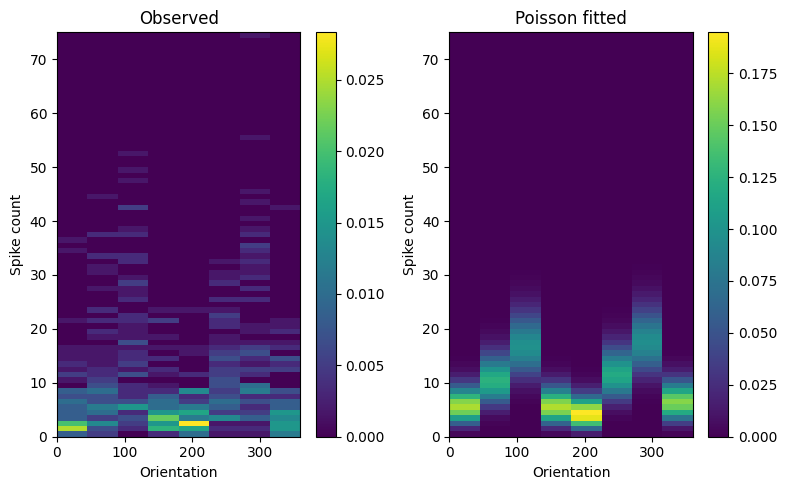

In [9]:
# fit a Poisson distribution based on the mean spike counts for each orientation
p_xgy_pois = np.zeros((max_counts+1, num_stim))
for i in range(num_stim):
    p_xgy_pois[:,i] = poisson_pdf(np.arange(max_counts+1), rf_ori_mean[0][i])

# plot the joint distribution and the Poisson fit
fig, ax = plt.subplots(1,2,figsize=(8,5))
ax[0].pcolormesh(x, y, joint_dist)
fig.colorbar(ax=ax[0], mappable=ax[0].collections[0])
ax[0].set_xlabel('Orientation')
ax[0].set_ylabel('Spike count')
ax[0].set_title('Observed')

ax[1].pcolormesh(x, y, p_xgy_pois)
fig.colorbar(ax=ax[1], mappable=ax[1].collections[0])
ax[1].set_xlabel('Orientation')
ax[1].set_ylabel('Spike count')
ax[1].set_title('Poisson fitted')

fig.tight_layout()

The match is not perfect. Our poisson distribution probabilities are generally larger than those of the observed joint distribution. This is because when we calculate the poisson probability for each orientation seperately, we are really calculating $p(x|y)$, which is a conditional probability. With a conditional probability the sum of $p(x|y)$ across all values of $x$ must equal 1.

You may also have noticed that the poisson distribution generally tends to be more concentrated around the mean spike count, with the observed distribution showing greater spread. This can be seen clearly if we plot the distribution for a single orientation. To do this, we will convert the fitted distribution which is conditional on $y$ to the joint probability, using $p(x,y)=p(x|y)p(y)$. It is easy to calculate $p(y)$ by just counting the number of trials for each orientation, and dividing by the total number of trials. We can use the observed joint probability distribution for that.

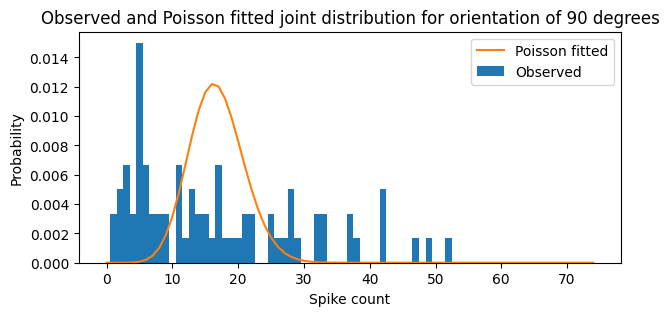

In [10]:
# calculate probability of each orientation being presented
p_y = joint_dist.sum(axis=0) / joint_dist.sum()

# calculate the joint distribution of spike counts and orientation 
# based on the Poisson fit
p_xy_pois = p_xgy_pois * p_y

fig, ax = plt.subplots(figsize=(7,3))
ax.bar(np.arange(max_counts+1), joint_dist[:,2], 1, label='Observed')
ax.plot(np.arange(max_counts+1), p_xy_pois[:,2], color='tab:orange', label='Poisson fitted')
ax.set_xlabel('Spike count')
ax.set_ylabel('Probability')
ax.set_title('Observed and Poisson fitted joint distribution for orientation of 90 degrees')
ax.legend()

Plotting the observed and fitted distributions this way lays bear the problem with assuming a Poisson fit. There are two likely explanations. The first is that the neuron's spiking does not behave like a poisson process. When we specify the wrong model for the process generating some data, this is referred to as *model misspecification*. Another reason is that we have pooled together all gratings that had the same orientation, but they vary in their temporal frequency. If the neuron was sensitive to the temporal frequency, it would have a different $\lambda$ for each one. Some temporal frequencies might elicit little or no spiking (producing a low $\lambda$), and others could activate robustly (high $\lambda$). This would give us a broad distribution of spike counts. 

Nevertheless, it might be good enough for the purpose of decoding which orientation was presented based on the spike count, $p(y|x)$. Since we are using Bayes' rule, we know that $p(y|x) \propto p(x|y)p(y)$. Thus, we can use the joint probability of the fitted distribution we just calculated, `p_xy_pois`, to determine the most likely stimulus for a given spike count.

Let's range over the various spike counts that were recorded and return the orientation that was most likely for each based on $p(x|y)p(y)$.

Text(0.5, 1.0, 'Predicted orientation based on spike count')

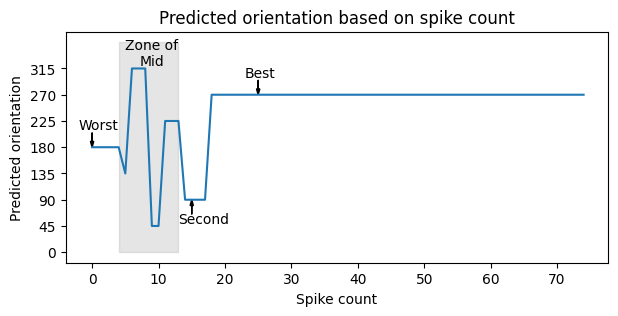

In [11]:
# initialize the spike counts and predicted orientations
spk_counts = np.arange(max_counts+1)
pred_ori = np.zeros(spk_counts.shape)

# predict the orientation based on the spike count using p(x|y) * p(y)
# here x is the observed spike count, which we use to index the row of p_xgy_pois
nb_pred = lambda x: ori_vals[np.argmax(p_xgy_pois[x,:] * p_y)]

for count in spk_counts:
    # selects the orientation with the highest probability for the given spike count
    pred_ori[count] = nb_pred(count)

fig, ax = plt.subplots(figsize=(7,3))
ax.plot(spk_counts, pred_ori)
ax.set_yticks(ori_vals)

# arrows denoting points of interest
ax.annotate('Worst', xy=(0, pred_ori[0]), xytext=(-2, pred_ori[0]+30))
ax.arrow(0, pred_ori[0]+25,0, -25, length_includes_head=True, head_width=0.5, head_length=10, fc='k', ec='k')
ax.annotate('Second', xy=(15, pred_ori[15]), xytext=(13, pred_ori[15]-40))
ax.arrow(15, pred_ori[15]-25,0, 25, length_includes_head=True, head_width=0.5, head_length=10, fc='k', ec='k')
ax.annotate('Best', xy=(25, pred_ori[25]), xytext=(23, pred_ori[25]+30))
ax.arrow(25, pred_ori[25]+25,0, -25, length_includes_head=True, head_width=0.5, head_length=10, fc='k', ec='k')

# add a transpancency beteen 5 and 12 spike counts and label it as 'moderate'
ax.fill_between(np.arange(4,14), 0, 360, color='gray', alpha=0.2)
ax.text(9, 320, 'Zone of\nMid', ha='center')

ax.set_xlabel('Spike count')
ax.set_ylabel('Predicted orientation')
ax.set_title('Predicted orientation based on spike count')

Well that was way easier than logistic regression! Once you have calculated the approximation of $p(y|x)$ from the the poisson fitted distribution (poisson fit of $p(x|y)$) and the probability of an orientation ($p(y)$), you just plug in the observed spike count and select the orientation that had the highest probability.

We can see here that for very low spike counts the stimulus eliciting the fewest spikes was selected ('Worst'). As we increase the number of observed spikes, the selected orientations bounces amongst the various stimuli that it shows a moderate response ('Zone of Mid'). Further increasing the spike count has the decoder returning the second most preferred stimulus ('Second'). Finally, above a count of ~20 spikes the decoder always returns the preferred stimulus ('Best').

So how does this decoder perform? For the moment, let's ignore issues with dividing our data into training and test sets and just evaluate the overall performance. This stacks the deck in the decoder's favor due to the potential for overfitting, so the performance we see here will probably be the highest it can be. 

In [12]:
# create an array of actual orientations and their corresponding spike counts

# first we take our counts dataframe and give each trial its own row
eval_nb = rf_ori_counts.explode('spike_counts').reset_index()

# then we predict the orientation based on the spike count
eval_nb['pred_ori'] = eval_nb['spike_counts'].apply(lambda x: nb_pred(int(x)))

# convert orientations to integers for display purposes
eval_nb['orientation'] = eval_nb['orientation'].astype(int)
eval_nb['pred_ori'] = eval_nb['pred_ori'].astype(int)

# calculate the accuracy of the model
score = balanced_accuracy_score(eval_nb['orientation'], eval_nb['pred_ori'])
print('Balanced accuracy score: {:.1f}%'.format(score*100))

Balanced accuracy score: 19.5%


Wow, only 19.5%! Given that there are 8 orientations, that gives us a chance performance of 100/8=12.5%. So we are better than chance, but still abyssmal. Ok, but why are we poor? Let's use a confusion matrix to figure this out.

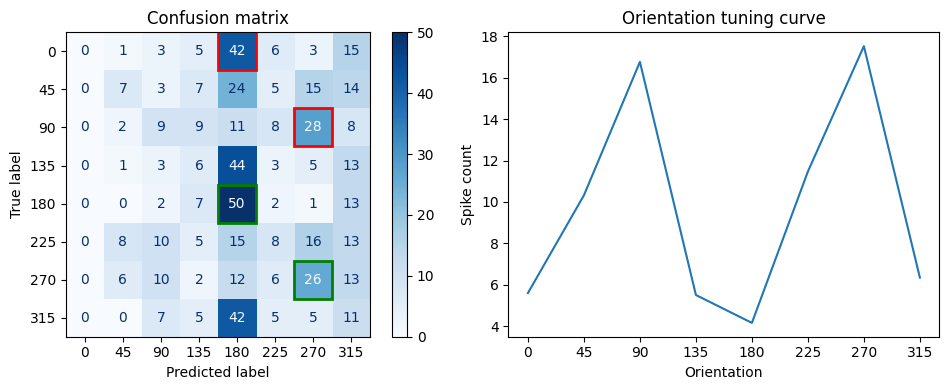

In [13]:
# create a confusion matrix
conf_mat = confusion_matrix(eval_nb['orientation'], eval_nb['pred_ori'])

# plot the confusion matrix
fig, ax = plt.subplots(1,2, figsize=(10,4))
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=ori_vals)
cmd.plot(ax=ax[0],cmap='Blues')
ax[0].set_title('Confusion matrix')
ax[0].set_xticklabels(map(int,ori_vals))
ax[0].set_yticklabels(map(int,ori_vals))

# draw red box around select incorrect classifications and green box around select correct classifications
ax[0].add_patch(plt.Rectangle((np.where(ori_vals==270)[0][0]-0.5, np.where(ori_vals==90)[0][0]-0.5), 1, 1, fill=False, edgecolor='red', lw=2))
ax[0].add_patch(plt.Rectangle((np.where(ori_vals==270)[0][0]-0.5, np.where(ori_vals==270)[0][0]-0.5), 1, 1, fill=False, edgecolor='green', lw=2))
ax[0].add_patch(plt.Rectangle((np.where(ori_vals==180)[0][0]-0.5, np.where(ori_vals==0)[0][0]-0.5), 1, 1, fill=False, edgecolor='red', lw=2))
ax[0].add_patch(plt.Rectangle((np.where(ori_vals==180)[0][0]-0.5, np.where(ori_vals==180)[0][0]-0.5), 1, 1, fill=False, edgecolor='green', lw=2))

ax[1].plot(ori_vals, rf_ori_mean[0])
ax[1].set_xticks(ori_vals)
ax[1].set_xlabel('Orientation')
ax[1].set_ylabel('Spike count')
ax[1].set_title('Orientation tuning curve')
fig.tight_layout()


Perhaps not surprisingly given the low performance, we do not see a nice diagonal of elevated instances of correct matchings between true and predicted labels. Instead, we see a column of elevated predictions at 180 degrees. Examining the tuning curve for orientation, we see that the 180 degree orientation evoked the least spiking on average, so whenever a stimulus evoked none or just a few spikes it was classified as that. Due to the broad distribution of spike counts at each orientation, with an elevated number at 0, this could go a long way to explaining the poor performance. For many presentations of the drifting grating just a few spike were elicited. This could be because the neuron has strong temporal frequency tuning, so if a drifting grating with a non-preferred temporal frequency is presented it will not respond. We will address this later by trying to predict both orientation and temporal frequency, but in the meantime let's see how far we can get just with orientation. 

Another notable feature of the confusion matrix is that it shows a repeating pattern along the True label axis. To highlight this, I have placed green and red boxes around selected entries in the confusion matrix. Those in green surround correct classifications, while those in red are for incorrect. You can see that when the true and predicted labels were both 180 degrees there was an elevated number of correct predictions. Moving to the case where the true label was 0 and the predicted was 180, we again see an elevated number of predictions. These true labels are 180 degrees apart, and indeed if you examine other entries in the 180 degrees prediction column you will find that the counts are similar for those 180 degrees apart. This was also the case when the predicted label was 270 degrees. Here there are 28 instances of correct predictions where the true label was 270 degrees and the predicted label was also 270. Moving 180 degrees, there is another bump in predictions (this time incorrect), at 90 degrees. Thus, the classifier is having trouble discriminating between orientations that are 180 degrees apart. 

The reason for this is apparent when we inspect the orientation tuning curve. Note how it has a triangular shape from 0 to 180 degrees, and that shape repeats again from 180 to 315. This is because the neuron is tuned to the orientation of the drifting grating, but does not care about the direction of motion. If the neuron fires a lot of spikes, it is likely that it was exposed to a drifting grating at either 90 or 270 degrees. Likewise, if it doesn't fire much, it is likely responding to a drifting grating oriented at 0 or 180 degrees. 

Due to these symmetries in orientation tuning, it is not possible to decode orientation using this single neuron. To overcome this, we can try pooling together multiple neurons, each with their own tuning curve. If these neurons also have a slight asymmetry in their responding to orientations 180 degrees apart, this may be sufficient to decode the entire range of orientations (0-360 degrees).

## Putting the *naive* into Naive Bayesian classification

So far we have tried to infer orientation from a single neuron using Bayes' rule. To do this, we calculated the probability of an orientation ($y$) given a measured spike count ($x$) by multiplying the probability that the count was observed for an orientation with the probability that the orientation was presented. Mathematically we expressed this as $p(x|y)p(y)$. The orientation with the higest probability is the one we predict was presented. However, symmetries in orientation tuning impeded our ability to decode with a single neuron. 

To overcome this, we will try to use the spiking from multiple neurons, presumably each with a different preferred orientation and some degree of asymmetry their orientation tuning. For instance, below is an example neuron with strong asymmetry in orientation tuning.

Text(0.5, 1.0, 'Asymmetric')

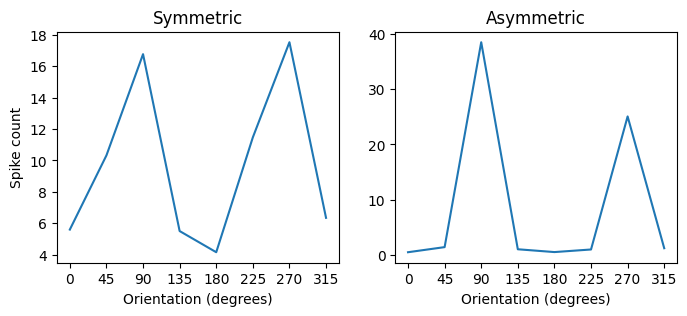

In [14]:
asym_unit =  951815256
rf_ori_asym_mean = spikes.loc[asym_unit,'rf_ori_emp']

fig, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].plot(ori_vals, rf_ori_mean[0].flatten())
ax[0].set_xticks(ori_vals)
ax[0].set_xlabel('Orientation (degrees)')
ax[0].set_ylabel('Spike count')
ax[0].set_title('Symmetric')
ax[1].plot(ori_vals, rf_ori_asym_mean[0].flatten())
ax[1].set_xticks(ori_vals)
ax[1].set_xlabel('Orientation (degrees)')
ax[1].set_title('Asymmetric')

Here are the orientation tuning curves for two different neurons. The first is the one we have been studying that has a mostly symmetric tuning. The one on the right has the same orientation tuning (peaking at 90 and 270 degrees), with with greater asymmetry in its response to its preferred orientations. Its response 90 degree drifting gratings is almost twice as strong as to those at 270 degrees. 

How can we use Bayes' rule to predict orientation using the responses of two different neurons? For this we want to solve for $p(y|x_1,x_2)$, where $x_1$ is the spike count from the first neuron and $x_2$ is the spike count from the second neuron. To calculate $p(y|x_1,x_2)$, we will make the ***naive*** assumption that the two neurons fire independently of each other. This simplifies calculating the joint probability because we do not have to estimate it for every possible combination of spike counts arising from the symmetric and asymmetric units. Instead, we just calculate their probabilities separately and then multiply to find their joint probability. Expressed mathematically, we would write:

$$ \begin{align}
    p(y|x_1,x_2) &\propto p(x_1,x_2|y)p(y) \notag \\
                 &\propto p(x_1|y)p(x_2|y)p(y) \notag \\
    \end{align}
$$

We can do this because the joint probability of two independent events is equal to their individual probabilities multiplied together, i.e. $p(x_1,x_2)=p(x_1)p(x_2)$. Making those probabilties conditional on $y$ (e.g. $p(x_1|y)$) does not change this so long as their independence is maintained for all possible values of $y$.

Thus, to decode the orientation we just need to multiply the poisson fitted count probabilities for the two units and plug in their corresponding observed spike counts.

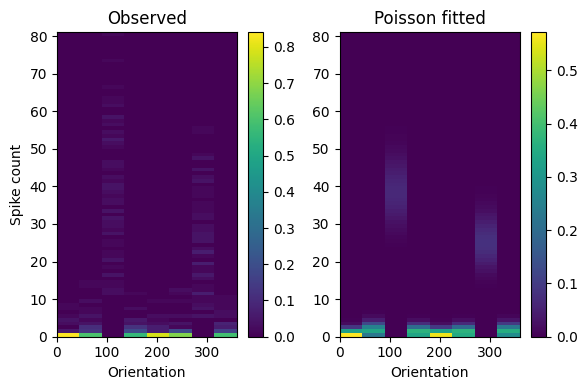

In [15]:
rf_ori_asym_counts = spikes.loc[asym_unit,'rf_ori'].stim_counts
max_counts_asym = int(rf_ori_asym_counts['spike_counts'].apply(lambda x: x.max()).max())

# get the joint probability distribution of spike counts and orientation
p_xy_asym = np.zeros((max_counts_asym+1, num_stim))
for i, (_, counts) in enumerate(rf_ori_asym_counts.iterrows()):
    p_xy_asym[:,i] = np.histogram(counts.values[0], bins=np.arange(max_counts_asym+2))[0]
p_xy_asym = p_xy_asym / p_xy_asym.sum()

# fit a Poisson distribution based on the mean spike counts for each orientation
p_xgy_pois_asym = np.zeros((max_counts_asym+1, num_stim)) 
for i in range(num_stim):
    p_xgy_pois_asym[:,i] = poisson_pdf(np.arange(max_counts_asym+1), rf_ori_asym_mean[0][i])

# compare the observed joint distribution and poisson fitted conditional distribution
x_asym, y_asym = np.meshgrid(np.append(ori_vals, 360), np.arange(max_counts_asym+2))
fig, ax = plt.subplots(1,2,figsize=(6,4))
ax[0].pcolormesh(x_asym, y_asym, p_xy_asym/p_y) # divide by p(y) to get p(x|y)
fig.colorbar(ax=ax[0], mappable=ax[0].collections[0])
ax[0].set_xlabel('Orientation')
ax[0].set_ylabel('Spike count')
ax[0].set_title('Observed')

ax[1].pcolormesh(x_asym, y_asym, p_xgy_pois_asym)
fig.colorbar(ax=ax[1], mappable=ax[1].collections[0])
ax[1].set_xlabel('Orientation')
ax[1].set_title('Poisson fitted')
fig.tight_layout()

This asymmetric unit shows many of the same differences between its observed spike counts and the poisson fits, such as sparseness of the observed counts and less dispersion of the counts at the preferred orientations. 

Now that we have poisson approximations for $p(x|y)$ for both units, let's try doing some decoding with them.

In [16]:
# predict the orientation based on the spike count using p(x_1|y) * p(x_2|y) * p(y)
# here x1 and x2 are the observed spike counts, which we use to index into the rows of p_xgy_pois and p_xgy_pois_asym
nb_pred_2 = lambda x1, x2: ori_vals[np.argmax(p_xgy_pois[int(x1),:] * p_xgy_pois_asym[int(x2),:] * p_y)]

# create dataframe with both spike counts broken out
eval_nb_2 = rf_ori_counts.explode('spike_counts').reset_index()
eval_nb_2_asym = rf_ori_asym_counts.explode('spike_counts').reset_index()
eval_nb_2_asym = eval_nb_2_asym.rename(columns={'spike_counts':'spike_counts_asym'})
eval_nb_2 = pd.concat([eval_nb_2, eval_nb_2_asym['spike_counts_asym']], axis=1)

# predict the orientation based on the spike counts
eval_nb_2['pred_ori'] = eval_nb_2.apply(lambda x: nb_pred_2(x['spike_counts'], x['spike_counts_asym']), axis=1)

# calculate the accuracy of the model
score = balanced_accuracy_score(eval_nb_2['orientation'], eval_nb_2['pred_ori'])
print('Balanced accuracy score: {:.1f}%'.format(score*100))


Balanced accuracy score: 35.7%


Nice! We almost doubled our accuracy. Mind you, it is still bad, but now we are about 3 times above chance. Let's examine the confusion matrix to see what is driving the improved performance.

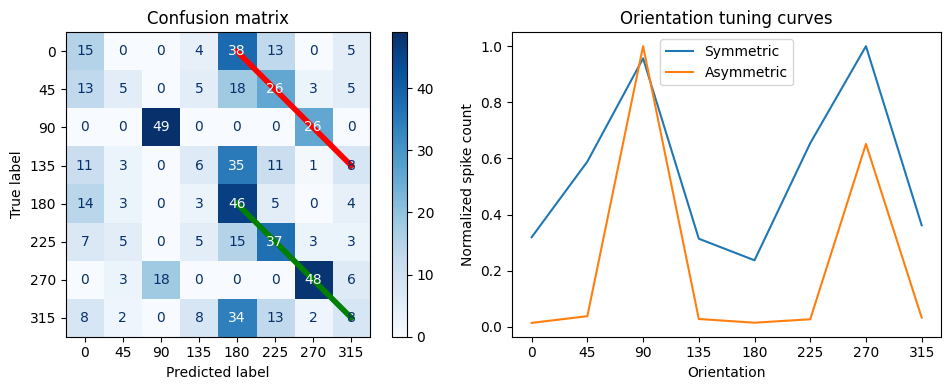

In [17]:
# create a confusion matrix
cmd_2 = confusion_matrix(eval_nb_2['orientation'], eval_nb_2['pred_ori'])

# plot the confusion matrix
fig, ax = plt.subplots(1,2, figsize=(10,4))
cmd_2_display = ConfusionMatrixDisplay(confusion_matrix=cmd_2, display_labels=ori_vals)
cmd_2_display.plot(ax=ax[0], cmap='Blues')
ax[0].set_title('Confusion matrix')
ax[0].set_xticklabels(map(int,ori_vals))
ax[0].set_yticklabels(map(int,ori_vals))
ax[0].plot([np.where(ori_vals==180)[0], np.where(ori_vals==315)[0]], 
           [np.where(ori_vals==0)[0], np.where(ori_vals==135)[0]], color='red', lw=4)
ax[0].plot([np.where(ori_vals==180)[0], np.where(ori_vals==315)[0]], 
           [np.where(ori_vals==180)[0], np.where(ori_vals==315)[0]], color='green', lw=4)
ax[1].plot(ori_vals, rf_ori_mean[0]/rf_ori_mean[0].max(), label='Symmetric')
ax[1].plot(ori_vals, rf_ori_asym_mean[0]/rf_ori_asym_mean[0].max(), label='Asymmetric')
ax[1].set_xticks(ori_vals)
ax[1].set_xlabel('Orientation')
ax[1].set_ylabel('Normalized spike count')
ax[1].set_title('Orientation tuning curves')
ax[1].legend()
fig.tight_layout()


Elevated levels of correct predictions are now starting to populate the diagonal of the confusion matrix. Notice that the preferred orientations at 90 and 270 degrees show few misclassifications, and when they do it is confusing between them. We still see some reflection of the classifications spaced at 180 degrees, resulting in missclassifications in the upper half of the confusion matrix (red diagonal line is miss, green is correct). Overcoming this will require incorporating neurons tuned to other orientations.

## Creating a naive bayes decoder class

At this point it will only get more cumbersome to scale up our piecemeal approach to decoding. Instead, we will create a class to encapsulate the process and make some improvements. We want it to behave similar to estimator classes in SciKit learn, which means at least defining `__init__()`, `fit`, `predict`, and `score` methods. In addition, instead of calculating a table of conditional probabilities ($p(x|y)$), for each unit we will just define $\lambda$ for each orientation, which can be passed with the spike counts to the poisson pdf equation to solve for the probability. This allows us to accomodate spike counts exceeding the maximum we had observed when calculating the table. Since it will be working with poisson count data, in the spirit of naming conventions for naive bayes classifiers in SciKit learn that use the distribution name, we will call our class `PoissonNB`.

In [18]:
class PoissonNB():
    def __init__(self):
        self.vals_y = None
        self.p_y = None
        self.params = None # parameter for each class and neuron [n_classes, n_neurons, ...]
    
    def _pdf(self, X):
        """
        Calculate the Poisson probability density function.

        Parameters
        ----------
        X : array-like, shape (n_features)
            A single input samples. For this model, it is the spike counts.
            Each entry corresponds to a neuron.

        Returns
        -------
        pdf : array-like, shape (n_classes, n_features)
            The Poisson probability densities for each sample and neuron.
        """

        if self.params is None:
            raise ValueError('Model has not been trained yet.')

        return (np.power(self.params, X) * np.exp(-self.params)) / factorial(X)
    
    def predict(self, X):
        """
        Predict the class of the input samples.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples. For this model, it is the spike counts.
            Each row to a sample and each column corresponds to a neuron.
        
        Returns
        -------
        y_pred : array-like, shape (n_samples)
            The predicted classes.
        """

        num_samples = X.shape[0]

        # calculate the likelihood of each class
        p_xgy = np.zeros((X.shape[0], len(self.vals_y)))
        for i in range(num_samples):
            p_xgy[i] = np.prod(self._pdf(X[i]), axis=1)
        
        # calculate the posterior probability of each class
        p_ygx = p_xgy * self.p_y

        # predict the class with the highest posterior probability
        y_pred = self.vals_y[np.argmax(p_ygx, axis=1)]

        return y_pred

    def score(self, X, y):
        """
        Calculate the balanced accuracy score of the model on the input samples.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples. For this model, it is the spike counts.
            Each row to a sample and each column corresponds to a neuron.
        y : array-like, shape (n_samples,)
            The target values.

        Returns
        -------
        score : float
            The balanced accuracy score of the model on the input samples.
        """

        y_pred = self.predict(X)
        score = balanced_accuracy_score(y, y_pred)

        return score

    def fit(self, X, y):
        """
        Fit the model to the data.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples. For this model, it is the spike counts.
            Each row to a sample and each column corresponds to a neuron.
        y : array-like, shape (n_samples,)
            The target values.

        Returns
        -------
        score : float
            The balanced accuracy score of the model on the training data.
        """

        # get the unique classes of y
        self.vals_y = np.unique(y)

        # calculate the prior probability of each class
        self.p_y = np.array([np.sum(y==c) / len(y) for c in self.vals_y])

        # calculate the parameters for each class
        self.params = np.zeros((len(self.vals_y), X.shape[1]))
        for i, c in enumerate(self.vals_y):
            self.params[i] = np.mean(X[y==c], axis=0)

        # calculate the balanced accuracy score
        score = self.score(X, y)

        return score


You should notice that our naive bayes estimator class is a lot simpler than the logistic regression ones we implemented before. The only attributes we need to store are the values of the `y` classes, their prior probability distribution (`p_y`), and the `params` to hold the $\lambda$ values for each neuron/feature at each class. Solving for `lambda` is easy as well, for each neuron we just take its mean count on every class. Prediction is easy as well. A vector of spike counts (shape = `[n_features]`) is passed to the `_pdf` method implementing the poisson probability density function. In that we use [Numpy broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) to calculate the probability for each class and neuron using the $\lambda\text{s}$ stored in `self.params` (shape = `[n_classes, n_features]`). The code for this, and it's mathematical translation, is:

|`(np.power(self.params, X) * np.exp(-self.params)) / factorial(X)` | $$ \frac{\lambda^x e^{-x}}{x!} $$ |
| -----| --------|
| Code | Equation|

This array of probabilities, which contains the values of $p(x \mid y)$ for each combination of neuron and class, are multiplied together for each class to give the probability of the spike counts given a particular class, $p(x \mid y_k)$.

|`p_xgy[i] = np.prod(self._pdf(X[i]), axis=1)` | $$ p(x \mid y_k)=\prod_{i=1}^{n}{p(x_i \mid y_k)} $$ |
| -----| --------|
| Code | Equation|

With $p(x \mid y)$, we can now incorporate the prior and solve for an approximation of the likelihood.

|`p_ygx = p_xgy * self.p_y` | $$ p(y \mid x) \propto p(x \mid y) p(y) $$ |
| -----| --------|
| Code | Equation|

And lastly, we identify the class of y with the highest probability and select it.



|`y_pred = self.vals_y[np.argmax(p_ygx, axis=1)]` | $$ \text{selection} = \arg\max_{y_k}p(y \mid x) $$ |
| -----| --------|
| Code | Equation|

With our new class, we can easily train a variety of decoders. Let's start with the same two cells we did tried predicting with before. Since the model parameters are fitted by just taking the mean, there is none of the randomness found in stochastic gradient decscent and so we should get the exact same performance.

In [19]:

X = eval_nb_2[['spike_counts', 'spike_counts_asym']].values.astype(int)
y = eval_nb_2['orientation'].values

model = PoissonNB()
score = model.fit(X, y)

print('Balanced accuracy score: {:.1f}%'.format(score*100))

Balanced accuracy score: 35.7%


Fantastic, the same performance! No reason to limit ourselves to just two neurons, let's feed in all the neurons that were recorded from and see how the decoder performs.

To do this, we will breakout each of their `spike_counts` dataframes into a 'tall' dataframe using `explode`. Then after some renaming and removing of columns we will concatenate them together. Essentially we are doing the same thing we did above to combine the spike counts across orientations for two neurons, but doing it with a for loop so we can handle all neurons in the `spikes` dataframe.

In [20]:

def spike_counts_dataframe(spikes, column):
    """
    Create a dataframe with the spike counts across all units.

    Parameters
    ----------
    spikes : pd.DataFrame
        The dataframe containing the spike counts.
    column : str
        The column to use for the spike counts.

    Returns
    -------
    counts : pd.DataFrame
        A dataframe with the spike counts for each unit.
    """

    # get the index names
    ind_names = spikes[column].iloc[0].index.names
    

    counts = pd.DataFrame()
    for i, row in spikes.iterrows():
        # create a dataframe with the spike counts for each orientation
        curr_counts = row[column].explode('spike_counts').reset_index()

        # rename the spike counts column to include the unit id
        curr_counts.rename(columns={'spike_counts':'counts_{}'.format(i)}, inplace=True)

        # if not first run through loop, drop orientation column
        if i != spikes.index.values[0]:
            curr_counts.drop(columns=ind_names, inplace=True)

        # merge the current counts with the previous counts
        counts = pd.concat([counts, curr_counts], axis=1)
    return counts

# create a dataframe with the spike counts for each unit
spikes['rf_ori_counts'] = spikes['rf_ori'].apply(lambda x: x.stim_counts)
counts_ori = spike_counts_dataframe(spikes, 'rf_ori_counts')

# display the dataframe
counts_ori.head()

This new dataframe is fairly straightforward. The index column is just for each trial that was presented, of which there was 600. The orientation for a given trial is stored in the `orientation` column, and the corresponding spike count for each neuron is stored in a column with the format `counts_{unit id number}`. With this, we can get our X and y inputs for the naive bayes decoder and train it up. Unlike last time, we will split our data into train and test sets to evaluate its performance more realistically.

Balanced accuracy score: 69.2%


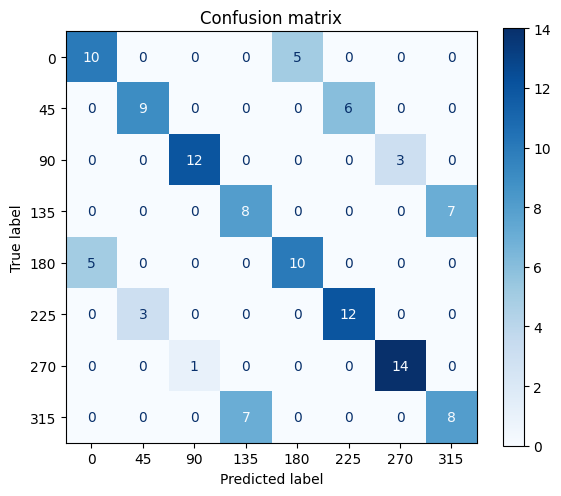

In [21]:
X = counts_ori.filter(like='counts').values.astype(int)
y = counts_ori['orientation'].values

# split into training and test sets
np.random.seed(42)
skf = StratifiedKFold(n_splits=5, shuffle=True)
train_idx, test_idx = next(skf.split(X, y))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

model = PoissonNB()
score = model.fit(X_train, y_train)
score_test = model.score(X_test, y_test)
print('Balanced accuracy score: {:.1f}%'.format(score_test*100))

# create a confusion matrix
conf_mat = confusion_matrix(y_test, model.predict(X_test))
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=ori_vals)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax, cmap='Blues')
ax.set_title('Confusion matrix')
ax.set_xticklabels(map(int,ori_vals))
ax.set_yticklabels(map(int,ori_vals))
fig.tight_layout()

Using all the units boosted the performance up to 72%. Examining the confusion matrix we can see that the errors occuring are driven by the 180 degree symmetry in orientation tuning. The diagonal of accurate prediction is strong now, but it continues to have misclassications that are offset by 180 degrees. This is probably because few of the neurons in our recording showed asymmetry in their tuning.

## Decoding temporal frequency

While the symmetry of orientation tuning limited our ability to decode it, the same should not be true for temporal frequency. Neurons typically changed their responses to temporal frequency as either increases or decreases in firing rate that did not reverse or repeat. This lack of a systematic similarity in the responses to different temporal frequencies should prevent a decoder from confusing them.

Let's train a naive bayes decoder for temporal frequency.

Balanced accuracy score: 51.7%


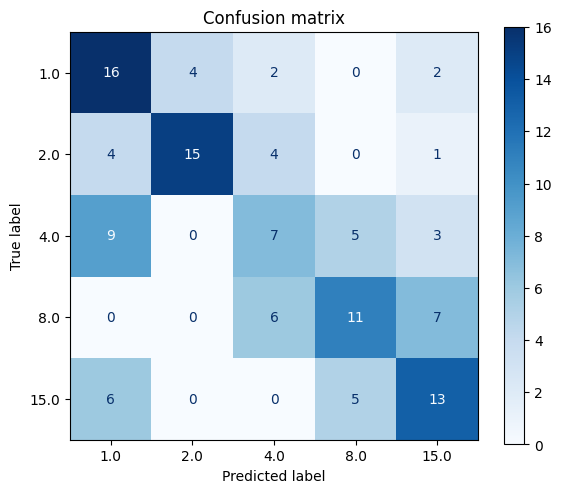

In [22]:
# spike counts for temporal frequency
spikes['rf_tf'] = spikes['times'].apply(lambda x: rf(dg_stims, [0, 2]).compute(x, dims=['temporal_frequency']))
spikes['rf_tf_counts'] = spikes['rf_tf'].apply(lambda x: x.stim_counts)

# create a dataframe with the spike counts for each unit
counts_tf = spike_counts_dataframe(spikes, 'rf_tf_counts')
tf_vals = counts_tf['temporal_frequency'].unique()

# prepare data for classification
X = counts_tf.filter(like='counts').values.astype(int)
y = counts_tf['temporal_frequency'].values

# split into training and test sets
np.random.seed(42)
train_idx, test_idx = next(skf.split(X, y))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

model = PoissonNB()
score = model.fit(X_train, y_train)
score_test = model.score(X_test, y_test)
print('Balanced accuracy score: {:.1f}%'.format(score_test*100))

# create a confusion matrix
conf_mat = confusion_matrix(y_test, model.predict(X_test))
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=tf_vals)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax, cmap='Blues')
ax.set_title('Confusion matrix')
fig.tight_layout()


The performance is much worse than what we got for orientation, but it is better than chance. Moreover, the structure of the confusion matrix shows a different distribution of errors. Most of the errors are slightly off the diagonal (instead of 180 degrees offset). This indicates that most of the errors are strongest between spatial frequencies that are similar.

## Decoding both temporal frequency and orientation

When decoding either orientation or temporal frequency we grouped together stimuli that had the same parameter for one of those dimensions, but varied in the other. For instance, when decoding orientation we pooled together those trials with orientations at 45 degrees, but those differed in their temporal frequency. Thus, the errors in performance could arise from the fact that variability in spiking driven by the non-decoded dimension interfered with the to-be-decoded dimension. One way to account for this is to train our decoder on both orientation and temporal frequency. To do this, each combination of orientation and temporal frequency is given a unique ID and the decoder learns to predict that ID based on spiking. We can then convert back from that ID to the corresponding orientation and temporal frequency.

Balanced accuracy score: 32.5%


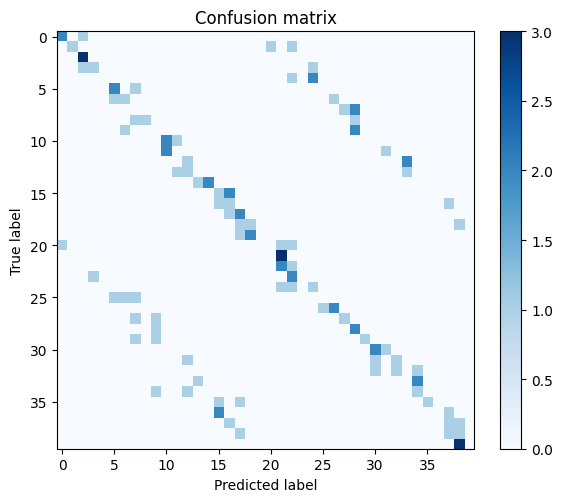

In [23]:
spikes['rf_oritf'] = spikes['times'].apply(lambda x: rf(dg_stims, [0, 2]).compute(x, dims=['orientation', 'temporal_frequency']))
spikes['rf_oritf_counts'] = spikes['rf_oritf'].apply(lambda x: x.stim_counts)

# create a dataframe with the spike counts for each unit
counts_oritf = spike_counts_dataframe(spikes, 'rf_oritf_counts')

# get the unique combinations of the columns 'orientation' and 'temporal_frequency'
stim_ids = counts_oritf[['orientation', 'temporal_frequency']].drop_duplicates().reset_index()
stim_ids['id'] = stim_ids.index
stim_ids.drop(columns='index', inplace=True)

# merge the counts dataframe with the stimulus ids
counts_oritf = counts_oritf.merge(stim_ids, on=['orientation', 'temporal_frequency'])

# prepare data for classification
X = counts_oritf.filter(like='counts').values.astype(int)
y = counts_oritf['id'].values

# split into training and test sets
np.random.seed(42)
train_idx, test_idx = next(skf.split(X, y))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

model = PoissonNB()
model.fit(X_train, y_train)
score_test = model.score(X_test, y_test)
print('Balanced accuracy score: {:.1f}%'.format(score_test*100))

# create a confusion matrix, do not display counts for each cell
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=stim_ids['id'])
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax, cmap='Blues')
ax.set_xticks(np.arange(0,len(stim_ids),5))
ax.set_yticks(np.arange(0,len(stim_ids),5))
ax.set_title('Confusion matrix')

# remove the counts for each cell, for display purposes
for text in cmd.text_:
    for t in text:
        t.set_text('')

fig.tight_layout()

Trying to decode the ID resulted in relatively poor performance. At ~33% we are much worse than our performance purely on orientation, and only marginally better than that for temporal frequency. You can see in the confusion matrix that the symmetry in orientation responsiveness is still cropping up. However, perhaps when we assign the IDs to their corresponding orientations and temporal frequencies the performance will be improved. 

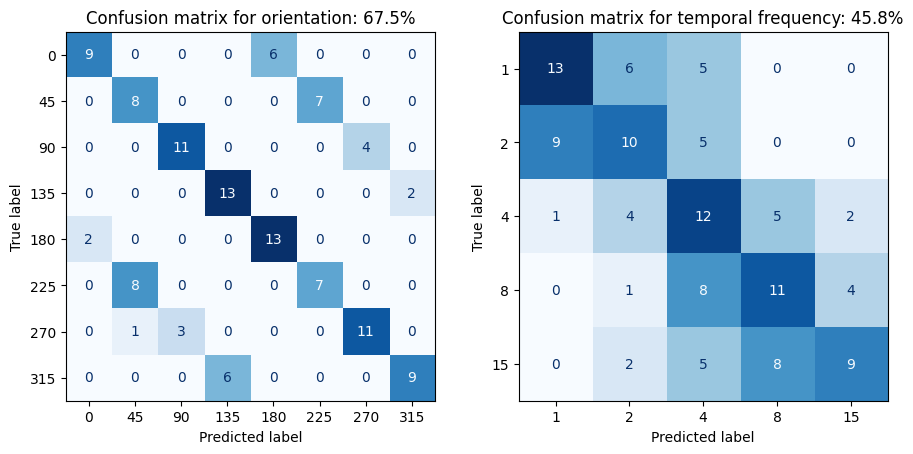

In [24]:
# get the predicted orientation and temporal frequency
y_pred_ori = stim_ids['orientation'].loc[y_pred].values
y_test_ori = stim_ids['orientation'].loc[y_test].values
score_ori = balanced_accuracy_score(y_test_ori, y_pred_ori)

y_pred_tf = stim_ids['temporal_frequency'].loc[y_pred].values
y_test_tf = stim_ids['temporal_frequency'].loc[y_test].values
score_tf = balanced_accuracy_score(y_test_tf, y_pred_tf)

# create a confusion matrix for the orientation
conf_mat_ori = confusion_matrix(y_test_ori, y_pred_ori)
cmd_ori = ConfusionMatrixDisplay(confusion_matrix=conf_mat_ori, display_labels=ori_vals)
fig, ax = plt.subplots(1,2,figsize=(10,5))
cmd_ori.plot(ax=ax[0], cmap='Blues')

ax[0].set_title('Confusion matrix for orientation: {:.1f}%'.format(score_ori*100))
ax[0].set_xticklabels(map(int,ori_vals))
ax[0].set_yticklabels(map(int,ori_vals))

# create a confusion matrix for the temporal frequency
conf_mat_tf = confusion_matrix(y_test_tf, y_pred_tf)
cmd_tf = ConfusionMatrixDisplay(confusion_matrix=conf_mat_tf, display_labels=tf_vals)
cmd_tf.plot(ax=ax[1], cmap='Blues')
ax[1].set_title('Confusion matrix for temporal frequency: {:.1f}%'.format(score_tf*100))
ax[1].set_xticklabels(map(int,tf_vals))
ax[1].set_yticklabels(map(int,tf_vals))
fig.get_children()[-1].remove()
fig.get_children()[-1].remove()
fig.tight_layout()


Nope, performance is still worse, slighty, than training on individual dimensions. One possible contributing factor is by splitting our data into 40 different groups (8 orientations x 5 temporal frequencies) we have noisy estimates of the mean response to each stimulus. This would impair our ability to decode on the test data that was held out during training.

Given how few knobs we have for optimizing the naive bayes classifier, it is worth asking if there are any additional ways we can improve our decoder's performance.

## Shared variability and noise correlations

One possible source of noise in our decoder is if neurons were spontaneously active irrespective of the stimuli presented. In this case, there would be increases or decreases in firing rate that on a single neuron level would throw off the decoder, since it uses the spike count to determine which stimulus was presented. If those spike counts are altered by spontaneous activity that is not stimulus related, then the decoder will assign incorrect probabilities. 

While it is difficult to address this problem for spiking variability that is not shared between neurons, there is a great deal of covariation in the spiking of neurons that is shared and is independent of the stimuli presented. Much work has been done on this under the name of [*noise correlations*](https://www.nature.com/articles/nn.2842) or *correlated variability*. We can observe this if we compare across trials the mean activity across half our units with the other half. Crucial to calculating the noise correlation is that we remove stimulus driven activity. To do that, we will subtract the mean response to each stimulus across trials from the response on each trial. This transformation leaves the activities that are not common across stimulus presentations.

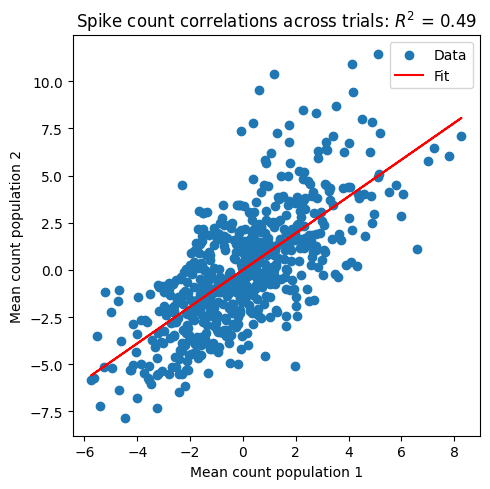

In [25]:
# get spike counts with stimulus related firing removed
spikes['rf_oritf_noise'] = spikes['rf_oritf_counts'].apply(lambda x: x['spike_counts'].apply(lambda y: y-np.mean(y)).values)
spikes['rf_oritf_noise'] = spikes['rf_oritf_noise'].apply(lambda x: np.stack(x).flatten())
X_noise = np.stack(spikes['rf_oritf_noise'].values).T

# Divide our units into two populations and calculate the mean spike count for each population
mean_pop1 = np.mean(X_noise[:,:22], axis=1)
mean_pop2 = np.mean(X_noise[:,22:], axis=1)

# Plot the mean spike count for each population across trials
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(mean_pop1,mean_pop2, label='Data')
m,b = np.polyfit(mean_pop1,mean_pop2,1)
ax.plot(mean_pop1, b+m*mean_pop1, color='red', label='Fit')
ax.set_xlabel('Mean count population 1')
ax.set_ylabel('Mean count population 2')
r_pop = np.corrcoef(mean_pop1,mean_pop2)[0,1]**2
ax.set_title('Spike count correlations across trials: $R^2$ = {:.2f}'.format(r_pop))
ax.legend()
fig.tight_layout()


There is a striking degree of correlation between noise activations across the two populations, reaching an $R^2$ close to 0.5! Often noise correlation is calculated between pairs of single neurons, and in that case the correlation is weaker, ~0.2.

This shared variability can negatively impact our ability to decode stimuli. Indeed, [attention tends to decrease](https://www.nature.com/articles/nn.3835) the noise correlation between neurons that are tuned to the same stimuli. To minimize it, we could z-score the spike count of each neuron separately, and then z-score those across neurons within a trial. Z-scoring each neuron separately across trials brings their spike counts into a common range so that those with generally very high or very low rates are equalized. This is important for the next stage, since it ensures that all neurons are weighted equally when the mean is calculated for the z-scoring operation, capturing above- or below-average levels of activation across all neurons on that trial. This mostly accounts for shared variability at the level of the entire population. 

If we do this transformation to our data, then we will convert our count data, which were intergers that ranged from 0 to infinity, to real number that vary from negative to positive infinity. This does not agree with the poisson distribution we use to calculate the probability. Instead, we have to switch to a gaussian distribution, which has the form:

$$ p(x) = \frac{1}{\sqrt{2\pi} SD}e^{\frac{-(x-M)^2}{2 SD^2}} $$

where SD is the standard deviation and M is the mean. This means we have to change our naive bayes estimator class to use the gaussian the distribution. We can accomplish this by inheriting from the `PoissonNB` class and changing the `_pdf` and `fit` methods. We will also need to specify both the mean and standard deviation in the `params` attribute.

In [26]:
class GaussNB(PoissonNB):
    def _pdf(self, x):
        """
        Calculate the Gaussian probability density function.

        Parameters
        ----------
        X : array-like, (n_features)
            A single input sample. For this model, it is the spike counts.
            Each entry corresponds to a neuron.
        
        Returns
        -------
        pdf : array-like, (n_classes, n_features)
            The Gaussian probability densities for each class and neuron.

        """

        if self.params is None:
            raise ValueError('Model has not been trained yet.')
        
        return norm.pdf(x, loc=self.params[:,:,0], scale=self.params[:,:,1])
    
    def fit(self, X, y):
        """
        Fit the model to the data

        Parameters
        ----------
        X : array-like, (n_samples, n_features)
            The training input samples. For this model, it is the spike counts.
            Each row to a sample and each column corresponds to a neuron.

        y : array-like, (n_samples)
            The target values.

        Returns
        -------
        score : float
            The balanced accuracy score of the model on the training data.
        """

        # get the unique classes of y
        self.vals_y = np.unique(y)

        # calculate the prior probability of each class
        self.p_y = np.array([np.sum(y==c) / len(y) for c in self.vals_y])

        # to fit the gusassian distribution we need to calculate the 
        # mean and standard deviation for each class and neuron
        self.params = np.zeros((len(self.vals_y), X.shape[1], 2))
        for i, c in enumerate(self.vals_y):
            self.params[i,:,0] = np.mean(X[y==c], axis=0) # mean, stored in first 'sheet'
            self.params[i,:,1] = np.std(X[y==c], axis=0) # standard deviation, stored in second 'sheet'
            
            # if the standard deviation is zero, set it to 1
            self.params[i,:,1][self.params[i,:,1]==0] = 1

        score = self.score(X, y)

        return score        


Now that we have our new class, let's give it a try on decoding orientation, but this time without controlling for share variability.

Balanced accuracy score: 70.8%


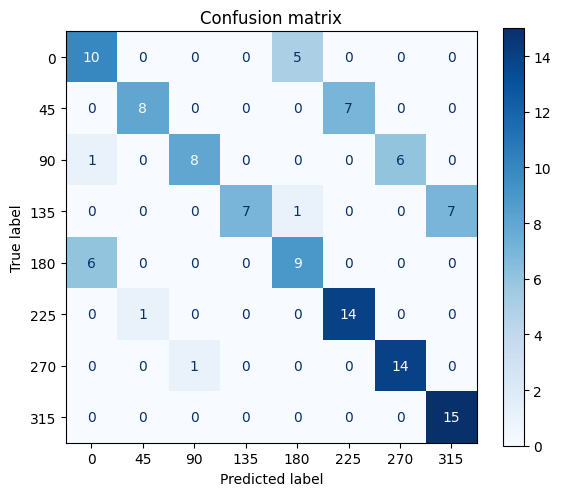

In [27]:
X = counts_ori.filter(like='counts').values.astype(int)
y = counts_ori['orientation'].values

# split into training and test sets
np.random.seed(42)
train_idx, test_idx = next(skf.split(X, y))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

model = GaussNB()
score = model.fit(X_train, y_train)
score_test = model.score(X_test, y_test)
print('Balanced accuracy score: {:.1f}%'.format(score_test*100))

# create a confusion matrix
conf_mat = confusion_matrix(y_test, model.predict(X_test))
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=ori_vals)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax, cmap='Blues')
ax.set_title('Confusion matrix')
ax.set_xticklabels(map(int,ori_vals))
ax.set_yticklabels(map(int,ori_vals))
fig.tight_layout()


Switching to a gaussian probability function left our decoder performance virtually unchanged. Let's try it with the shared variability removed.

Balanced accuracy score: 76.7%


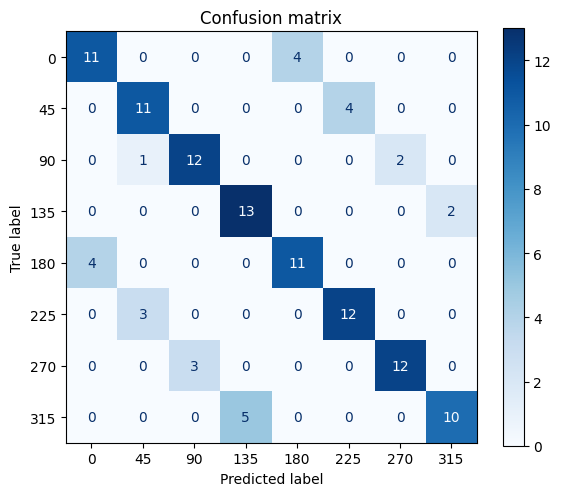

In [28]:
rem_noise = lambda x: zscore(zscore(x, axis=1), axis=0)
y = counts_ori['orientation'].values

# split into training and test sets
np.random.seed(42)
train_idx, test_idx = next(skf.split(X, y))
X_train, X_test = rem_noise(X[train_idx]), rem_noise(X[test_idx])
y_train, y_test = y[train_idx], y[test_idx]

model = GaussNB()
score = model.fit(X_train, y_train)
score_test = model.score(X_test, y_test)
print('Balanced accuracy score: {:.1f}%'.format(score_test*100))

# create a confusion matrix
conf_mat = confusion_matrix(y_test, model.predict(X_test))
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=ori_vals)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax, cmap='Blues')
ax.set_title('Confusion matrix')
ax.set_xticklabels(map(int,ori_vals))
ax.set_yticklabels(map(int,ori_vals))
fig.tight_layout()


Well that boosted performance. We went from ~71% to ~77%, a real improvement! Thus, removing shared variability that was stimulus independent increased our decoder's effectiveness. 

At this point you might be wondering if the performance could reach 100% if we increased the number of neurons we recorded. Perhaps this would happen if we had enough units with even a slight asymmetry in their response to orientations that were 180 degrees apart. We can explore this question by seeing how our decoder performs as we vary the number of units used. To do this, we will train the decoder on `n_units` randomly selected units, doing this 10 times for sample a different subset of the population. As we increase the number of units sampled, we should observe a systematic relationship with the decoder performance. Few units should yield poor performance, and using all the units should yield the performance we saw above. The curve traced out by intermediate numbers of units will tell us what to predict as we add more units beyond what we have in the current data set.

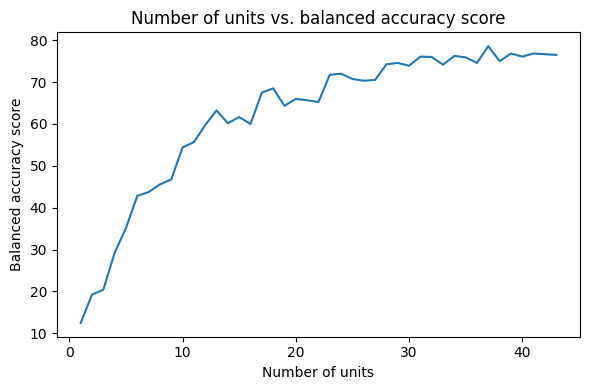

In [29]:
# iterate over different numbers of units, train the model and calculate the score on test data 10 times
# store the scores in a numpy array
num_units = X.shape[1]
scores = np.zeros((num_units,10))
for n_units in range(num_units):
    for rep in range(10):
        # randomly select n_units
        unit_idx = np.random.choice(num_units, n_units, replace=False)

        model = GaussNB()
        model.fit(X_train[:,unit_idx], y_train)
        scores[n_units, rep] += model.score(X_test[:,unit_idx], y_test)

# plot the scores
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(1, num_units+1), np.mean(scores, axis=1)*100)
ax.set_xlabel('Number of units')
ax.set_ylabel('Balanced accuracy score')
ax.set_title('Number of units vs. balanced accuracy score')
fig.tight_layout()

As we increase the number of units used for decoding, we can see the performance asymptote just below 80%. Performance rapidly increased from chance to ~50% at 10 units, then got slower and slower for each additional 10 units that were added. This indicates that adding more units, not even doubling them, would substantially improve performance. This may reflect a fundamental limitation of the symmetry in how orientations are represented in primary visual cortex.

We can test this hypothesis by examining how performance varies with number of units for coding of temporal frequency, which does not exhibit any such symmetry.

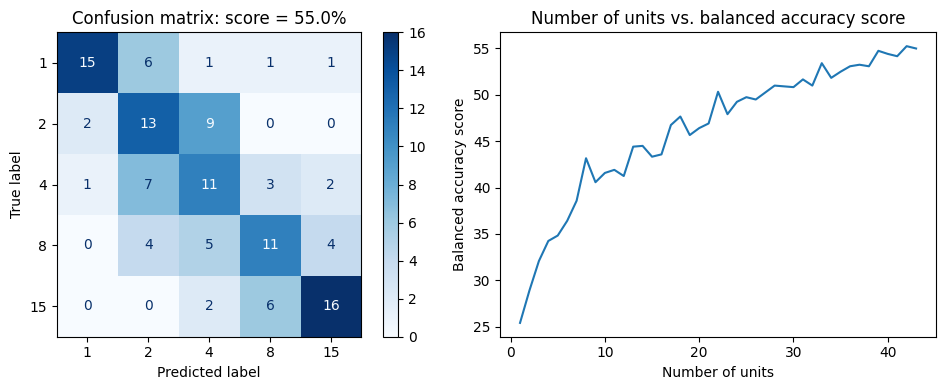

In [30]:
# determine how the number of untis affects the test score for decoding temporal frequency
X = counts_tf.filter(like='counts').values.astype(int)
y = counts_tf['temporal_frequency'].values

# split into training and test sets
np.random.seed(42)
train_idx, test_idx = next(skf.split(X, y))
X_train, X_test = rem_noise(X[train_idx]), rem_noise(X[test_idx])
y_train, y_test = y[train_idx], y[test_idx]

num_units = X.shape[1]

# iterate over different numbers of units, train the model and calculate the score on test data 10 times
scores = np.zeros((num_units,10))
for n_units in range(1,num_units+1):
    for rep in range(10):
        # randomly select n_units
        unit_idx = np.random.choice(num_units, n_units, replace=False)

        model = GaussNB()
        model.fit(X_train[:,unit_idx], y_train)
        scores[n_units-1, rep] += model.score(X_test[:,unit_idx], y_test)


fig, ax = plt.subplots(1,2,figsize=(10,4))
# plot confusion matrix
conf_mat = confusion_matrix(y_test, model.predict(X_test[:,unit_idx]))
score_test = model.score(X_test[:,unit_idx], y_test)
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=tf_vals)
cmd.plot(ax=ax[0], cmap='Blues')
ax[0].set_title('Confusion matrix: score = {:.1f}%'.format(score_test*100))
ax[0].set_xticklabels(map(int,tf_vals))
ax[0].set_yticklabels(map(int,tf_vals))

ax[1].plot(np.arange(1, num_units+1), np.mean(scores, axis=1)*100)
ax[1].set_xlabel('Number of units')
ax[1].set_ylabel('Balanced accuracy score')
ax[1].set_title('Number of units vs. balanced accuracy score')

fig.tight_layout()

While performance is overall worse for temporal frequency, its increase appears to show no sign of asymptoting. Thus, adding additional units should further improve our ability to decode, potentially to near perfect levels.